In [1]:
# Imports
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
S0, S0_ = 100, 100 # initial value
r = 0.05  # constant short rate
sigma = 0.25  # constant volatility
T = 2.0  # time in years
M = 50 # maturity
I = 10000  # number of random draws

dt = T / M
S_1 = np.zeros((M + 1, I))
S_2 = np.zeros((M + 1, I))

S_1[0] = S0
S_2[0] = S0_

for t in range(1, M + 1):
    S_1[t] = S_1[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma * np.sqrt(dt) * npr.standard_normal(I))
    S_2[t] = S_2[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma * np.sqrt(dt) * npr.standard_normal(I))

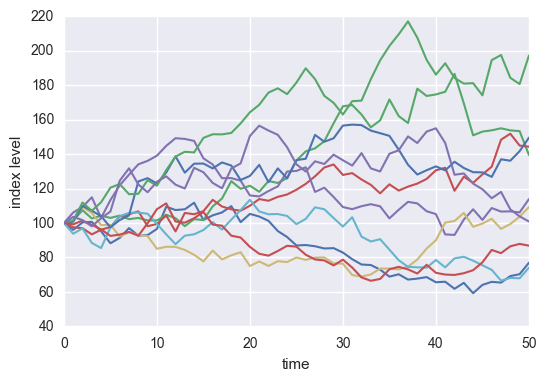

In [3]:
plt.plot(S_1[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
# tag: gbm_dt_paths
# title: Simulated geometric Brownian motion paths
# size: 60

In [4]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)
# tag: gbm_dt_hist
# title: Simulated geometric Brownian motion at maturity
# size: 60

NameError: name 'S' is not defined

In [ ]:
strike = np.linspace(50, 150, 24)
ttm = np.linspace(0.5, 2.5, 24)
strike, ttm = np.meshgrid(strike, ttm)


iv = (strike - 100) ** 2 / (100 * strike) / ttm
  # generate fake implied volatilities

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(strike, ttm, iv, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_xlabel('strike')
ax.set_ylabel('time-to-maturity')
ax.set_zlabel('implied volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)
# tag: matplotlib_17
# title: 3d surface plot for (fake) implied volatilities
# size: 70